# News Category Classification Project

## News Crawling

In [3]:
# 크롤러를 만들기 전 필요한 도구들을 임포트
import requests
import pandas as pd
from bs4 import BeautifulSoup
from newspaper import Article
import matplotlib.pyplot as plt
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

# 페이지 수, 카테고리, 날짜를 입력
def make_urllist(page_num, code, date): 
  urllist= []
  for i in range(1, page_num + 1):
    url = 'https://news.naver.com/main/list.nhn?mode=LSD&mid=sec&sid1='+str(code)+'&date='+str(date)+'&page='+str(i)
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/54.0.2840.90 Safari/537.36'}
    news = requests.get(url, headers=headers)

    # BeautifulSoup의 인스턴스 생성
    soup = BeautifulSoup(news.content, 'html.parser')

    # CASE 1
    news_list = soup.select('.newsflash_body .type06_headline li dl')
    # CASE 2
    news_list.extend(soup.select('.newsflash_body .type06 li dl'))
        
    # 각 뉴스로부터 a 태그인 <a href ='주소'> 에서 '주소'출력
    for line in news_list:
        urllist.append(line.a.get('href'))
  return urllist

In [4]:
#코드 네이밍
idx2word = {'101' : '경제', '102' : '사회', '103' : '생활/문화', '105' : 'IT/과학'}

In [5]:
# 데이터프레임을 생성
def make_data(urllist, code):
  text_list = []
  for url in urllist:
    article = Article(url, language='ko')
    article.download()
    article.parse()
    text_list.append(article.title)

  #- 데이터프레임의 'news' 키 아래 파싱한 텍스트를 밸류
  df = pd.DataFrame({'news': text_list})

  #- 데이터프레임의 'code' 키 아래 한글 카테고리명
  df['code'] = idx2word[str(code)]
  return df

In [6]:
url_list = make_urllist(2, 105, 20231128)
print('뉴스 기사의 개수: ',len(url_list))
url_list[:5]

뉴스 기사의 개수:  40


['https://n.news.naver.com/mnews/article/009/0005222155?sid=105',
 'https://n.news.naver.com/mnews/article/092/0002313077?sid=105',
 'https://n.news.naver.com/mnews/article/008/0004967473?sid=105',
 'https://n.news.naver.com/mnews/article/056/0011611479?sid=105',
 'https://n.news.naver.com/mnews/article/056/0011611472?sid=105']

In [7]:
def make_total_data(page_num, code_list, date_list):
    df = None
    for date in date_list:
        for code in code_list:
            url_list = make_urllist(page_num, code, date)
            df_temp = make_data(url_list, code)
            print(f'{date} - {code}번 코드에 대한 데이터를 만들었습니다.')
            if df is not None:
                df = pd.concat([df, df_temp])
            else:
                df = df_temp
    return df

In [10]:
date_list = [20231127, 20231128, 20231129]  # 크롤링할 날짜 리스트
code_list = [101, 102, 103, 105]  # 뉴스 카테고리 코드 리스트
df = make_total_data(3, code_list, date_list)

20231127 - 101번 코드에 대한 데이터를 만들었습니다.
20231127 - 102번 코드에 대한 데이터를 만들었습니다.
20231127 - 103번 코드에 대한 데이터를 만들었습니다.
20231127 - 105번 코드에 대한 데이터를 만들었습니다.
20231128 - 101번 코드에 대한 데이터를 만들었습니다.
20231128 - 102번 코드에 대한 데이터를 만들었습니다.
20231128 - 103번 코드에 대한 데이터를 만들었습니다.
20231128 - 105번 코드에 대한 데이터를 만들었습니다.
20231129 - 101번 코드에 대한 데이터를 만들었습니다.
20231129 - 102번 코드에 대한 데이터를 만들었습니다.
20231129 - 103번 코드에 대한 데이터를 만들었습니다.
20231129 - 105번 코드에 대한 데이터를 만들었습니다.


In [11]:
print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  720


In [12]:
import os

# 데이터프레임 파일을 csv 파일로 저장합니다.
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df.to_csv(csv_path, index=False)

if os.path.exists(csv_path):
  print('{} File Saved!'.format(csv_path))

/aiffel/aiffel/news_crawler/news_data.csv File Saved!


## Data Processing

In [17]:
csv_path = os.getenv("HOME") + "/aiffel/news_crawler/news_data.csv"
df = pd.read_table(csv_path, sep=',')
df.head()

,news,code
0,NaN,경제
1,"오뚜기, 가격 인상 계획 철회...""물가안정 기조에 동참""",경제
2,"독일 전기 에어택시 릴리움, EU 첫 승인 획득",경제
3,"설악산 오색케이블카, 흑자 운영 가능할까?",경제
4,"청년 세대, 30년 뒤 절반으로...5명 중 4명 미혼",경제


In [18]:
df.isna().sum()

news    1
code    0
dtype: int64

In [19]:
# 첫번째 행에 nan 오류가 있어 제거
df.dropna(inplace=True)

In [20]:
# 정규 표현식을 이용해서 한글 외의 문자는 전부 제거
df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
df['news']

/tmp/ipykernel_31/950953648.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['news'] = df['news'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


1               오뚜기 가격 인상 계획 철회물가안정 기조에 동참
2                  독일 전기 에어택시 릴리움  첫 승인 획득
3                    설악산 오색케이블카 흑자 운영 가능할까
4                   청년 세대 년 뒤 절반으로명 중 명 미혼
5         국세청 법인세법 가이드 시리즈로 발간이번엔 합병분할 세제편
                      ...                 
715                  퀄컴 이노베이션 펠로우십 코리아  성료
716           년  뮤 저력 입증한 웹젠신규투자 더해 투트랙 전략
717      대놓고 아이폰 자랑하더니 유명 아이돌 애플 사랑 이유 있었네
718                    스마일게이트   그랜드 파이널 개막
719    조성경 차관 연구장비 운영인력 전폭 지원할 것도입기간 일로 단축
Name: news, Length: 719, dtype: object

In [21]:
# 중복된 샘플 제거
df.drop_duplicates(subset=['news'], inplace=True)

print('뉴스 기사의 개수: ',len(df))

뉴스 기사의 개수:  649


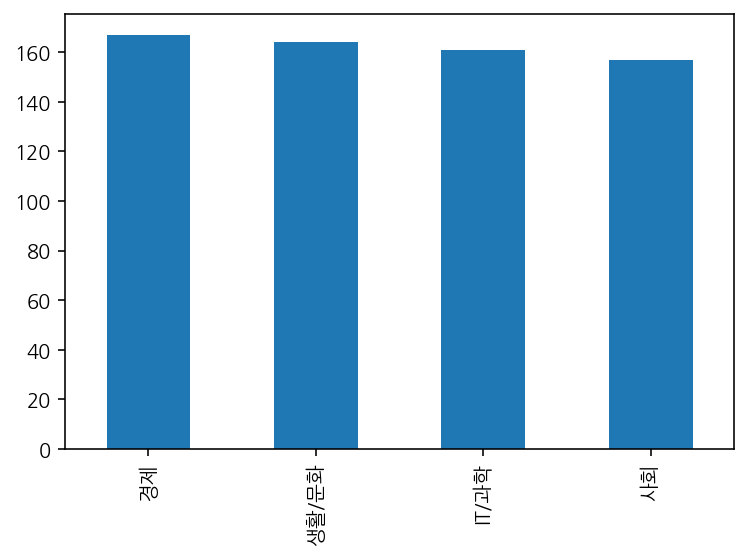

In [22]:
df['code'].value_counts().plot(kind='bar')
plt.show()

In [23]:
print(df.groupby('code').size().reset_index(name = 'count'))

    code  count
0  IT/과학    161
1     경제    167
2     사회    157
3  생활/문화    164


In [24]:
from konlpy.tag import Mecab

tokenizer = Mecab()

#- kor_text에 csv 파일 내용 넣기
kor_text = df['news'].to_string(index=False)

#- 형태소 분석, 즉 토큰화(tokenization)를 합니다.
print(tokenizer.morphs(kor_text))

['오뚜기', '가격', '인상', '계획', '철회', '물가', '안정', '기조', '에', '동참', '독일', '전기', '에어택시', '릴리', '움', '첫', '승인', '획득', '설악산', '오색', '케이블카', '흑자', '운영', '가능', '할까', '청년', '세대', '년', '뒤', '절반', '으로', '명', '중', '명', '미혼', '국세청', '법인세법', '가이드', '시리즈', '로', '발간', '이번', '엔', '합', '병분', '할', '세제', '편', '단독', '부산', '엑스포', '개최지', '선정', '앞두', '고', '부산', '로마', '연대', '가시', '화', '포토', '화학', '물질', '저감', '우수', '제품', '발표', '울주군', '지역', '투자', '유치', '환경', '개선', '사업', '공모', '선정', '울산', '휘발유', '와', '경유', '가격', '주', '연속', '하락', '울산', '주력', '업종', '월', '경기', '전망', '기준치', '밑돌', '아', '올', '댓', '차', '이나', '리얼', '미', '스마트폰', '출하량', '년', '만', '에', '억대', '돌파', '반유대주의', '논란', '머스크', '하마스', '제거', '돼야', '맞장구', '울산', '도심', '융합', '특구', '그린벨트', '해제', '절차', '본격', '화', '포토', '크리스마스', '분위기', '물씬', '루시드', '신차', '발표', '에', '도', '투자', '등급', '보유', '로', '내려가', '용인', '특례시', '일자리', '창출', '우수', '기업', '곳', '에', '인증서', '현판', '수여', '초미세', '먼지', '고농', '도', '조기', '예보', '충청', '호남', '으로', '확대', '김동연', '경기', '지사', '스페인', '카탈루냐', '주지사', '면담', '옷', '

In [25]:
stopwords = ['에','는','은','을','했','에게','있','이','의','하','한','다','과','때문','할','수','무단','따른','및','금지','전재','경향신문','기자','는데','가','등','들','파이낸셜','저작','등','뉴스', '도',  '인', '서', '올', '와', '내일’, ‘형’, ‘로’, ‘시대’, ’곳', '과', '또', '하는', '하', '는', '속' ,'제' ,'도' ,'덜' ,'본', '부터', '전', '지역', '새', '까지', ]

In [26]:
#불용어 개수 확인
print(len(stopwords))

52


In [27]:
# 토큰화 및 토큰화 과정에서 불용어를 제거하는 함수입니다.
def preprocessing(data):
  text_data = []

  for sentence in data:
    temp_data = []
    #- 토큰화
    temp_data = tokenizer.morphs(sentence) 
    #- 불용어 제거
    temp_data = [word for word in temp_data if not word in stopwords] 
    text_data.append(temp_data)

  text_data = list(map(' '.join, text_data))

  return text_data

In [28]:
text_data = preprocessing(df['news'])
print(text_data[0])

오뚜기 가격 인상 계획 철회 물가 안정 기조 동참


## Modeling

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

In [30]:
#- 훈련 데이터와 테스트 데이터를 분리합니다.
X_train, X_test, y_train, y_test = train_test_split(text_data, df['code'], random_state = 0)

In [31]:
print('훈련용 뉴스 기사의 개수 :', len(X_train))
print('테스트용 뉴스 기사의 개수 : ', len(X_test))
print('훈련용 레이블의 개수 : ', len(y_train))
print('테스트용 레이블의 개수 : ', len(y_test))

훈련용 뉴스 기사의 개수 : 486
테스트용 뉴스 기사의 개수 :  163
훈련용 레이블의 개수 :  486
테스트용 레이블의 개수 :  163


In [32]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [33]:
def tfidf_vectorizer(data):
  data_counts = count_vect.transform(data)
  data_tfidf = tfidf_transformer.transform(data_counts)
  return data_tfidf

In [34]:
y_pred = clf.predict(tfidf_vectorizer(X_test))
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       IT/과학       0.63      0.66      0.64        41
          경제       0.74      0.61      0.67        51
          사회       0.52      0.44      0.47        39
       생활/문화       0.38      0.53      0.44        32

    accuracy                           0.56       163
   macro avg       0.56      0.56      0.56       163
weighted avg       0.59      0.56      0.57       163



# Retrospective

처음 진행해본 프로젝트였는데, 
크롤링에서 HTML을 읽어 원하는 부분을 추출하는 것이 익숙하지 않아 시간이 오래 걸리는 것 같다.<br/>
하지만 코드는 생각보다 길지 않은 코드로 크롤링과 모델링까지 진행할 수 있어 놀라웠다.<br/>
아직 코드는 천천히 익숙해져야 할 것 같다.<br/>
<br/>
IT/과학, 경제의 f1-score가 사회, 생활/문화 보다 높은 점수가 나왔는데<br/>
전문 용어의 사용 비중이 있는 카테고리와 일반적인 단어가 많이 나오는 카테고리의 차이가 아닐까 생각이 들었다.<br/>

모델의 점수를 높이기 위해 Stopword와 Tokenizer에 다양한 변화를 주었으나 f1-score를 80점까지 끌어올리지 못했지만<br/>
모델링까지 진행해보았던 것에 만족했다.